PSF Model Fit Parameter Comparison

This notebook loads PSF model fit parameters for one DC2 patch. The models are:
- DoubleShapelet PSF parameters from meas_modelfit (used by CModel). This model estimates shape parameters from the moments of the PSF image and keeps those fixed for both components. The total fluxes of both components can vary.
- MultiProFit double gaussian. All parameters are free, except that the total fluxes are constrained to sum to one so that the model is normalized. 

In [1]:
# imports
from gauss2d.utils import covar_to_ellipse
import lsst.daf.butler as dafButler
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

In [2]:
# setup
repo = "/repo/dc2"
collection = "u/dtaranu/tickets/DM-42157-08/fit_ugrizy_match_ser"
skymap = "DC2"
butler = dafButler.Butler(repo, skymap=skymap, collections=[collection])
tract = 3828

sns.set(style="whitegrid")
plt.rcParams['axes.formatter.min_exponent'] = 3

In [3]:
# load data
bands = ("u", "g", "r", "i", "z", "y")
patches = (24,)
prefix_mmf_in = "modelfit_DoubleShapeletPsfApprox_"
columns_mmf = tuple(f"{prefix_mmf_in}{suffix}" for suffix in (
    "0_xx",
    "0_yy",
    "0_xy",
    "0_x",
    "0_y",
    "0_0",
    "1_xx",
    "1_yy",
    "1_xy",
    "1_0",
    "flag",
))
prefix_mmf = "mmf_psf_comp"
prefix_mpf = "mpf_psf_comp"
prefixes = {
    "mpf": prefix_mpf,
    "mmf": prefix_mmf,
}
tables = {}

for band in bands:
    for patch in patches:
        name = f"{band}_{patch}"
        table = butler.get("deepCoadd_psfs_multiprofit", collections=[collection], patch=patch, tract=tract, band=band, storageClass="ArrowAstropy")
        table.rename_column("mpf_psf_comp1_fluxfrac", "mpf_psf_comp1_flux")
        table["mpf_psf_comp2_flux"] = 1.0 - table["mpf_psf_comp1_flux"]
        table_mmf = butler.get("deepCoadd_meas", collections=[collection], patch=patch, tract=tract, band=band).asAstropy()[columns_mmf]
        for idx_comp in range(2):
            idx_out = idx_comp + 1
            sigma_xx = table_mmf[f"{prefix_mmf_in}{idx_comp}_xx"]
            sigma_xy = table_mmf[f"{prefix_mmf_in}{idx_comp}_xy"]
            sigma_yy = table_mmf[f"{prefix_mmf_in}{idx_comp}_yy"]
            table[f"{prefix_mmf}{idx_out}_sigma_x"] = np.sqrt(sigma_xx)
            table[f"{prefix_mmf}{idx_out}_sigma_y"] = np.sqrt(sigma_yy)
            # area = pi*r_det^2
            area = np.pi*np.sqrt(sigma_xx*sigma_yy - sigma_xy**2)
            table[f"{prefix_mmf}{idx_out}_area"] = area
            table[f"{prefix_mmf}{idx_out}_rho"] = sigma_xy/np.sqrt(sigma_xx*sigma_yy)
            table[f"{prefix_mmf}{idx_out}_flux"] = table_mmf[f"{prefix_mmf_in}{idx_comp}_0"]*2*np.sqrt(np.pi)
            table[f"{prefix_mmf}{idx_out}_rtrace"] = np.sqrt(0.5*(sigma_xx + sigma_yy))
            _, table[f"{prefix_mmf}{idx_out}_axrat"], table[f"{prefix_mmf}{idx_out}_ang"] = covar_to_ellipse(
                sigma_xx, sigma_yy, sigma_xy, degrees=True
            ) 
            # hold sigma_x,y temporarily
            sigma_xx = table[f"{prefix_mpf}{idx_out}_sigma_x"]
            sigma_yy = table[f"{prefix_mpf}{idx_out}_sigma_y"]
            sigma_xy = table[f"{prefix_mpf}{idx_out}_rho"]*sigma_xx*sigma_yy
            sigma_xx = sigma_xx**2
            sigma_yy = sigma_yy**2
            _, table[f"{prefix_mpf}{idx_out}_axrat"], table[f"{prefix_mpf}{idx_out}_ang"] = covar_to_ellipse(
                sigma_xx, sigma_yy, sigma_xy, degrees=True
            )
            table[f"{prefix_mpf}{idx_out}_area"] = np.pi*np.sqrt(sigma_xx*sigma_yy - sigma_xy**2)
            table[f"{prefix_mpf}{idx_out}_rtrace"] = np.sqrt(0.5*(sigma_xx + sigma_yy))
        tables[name] = table

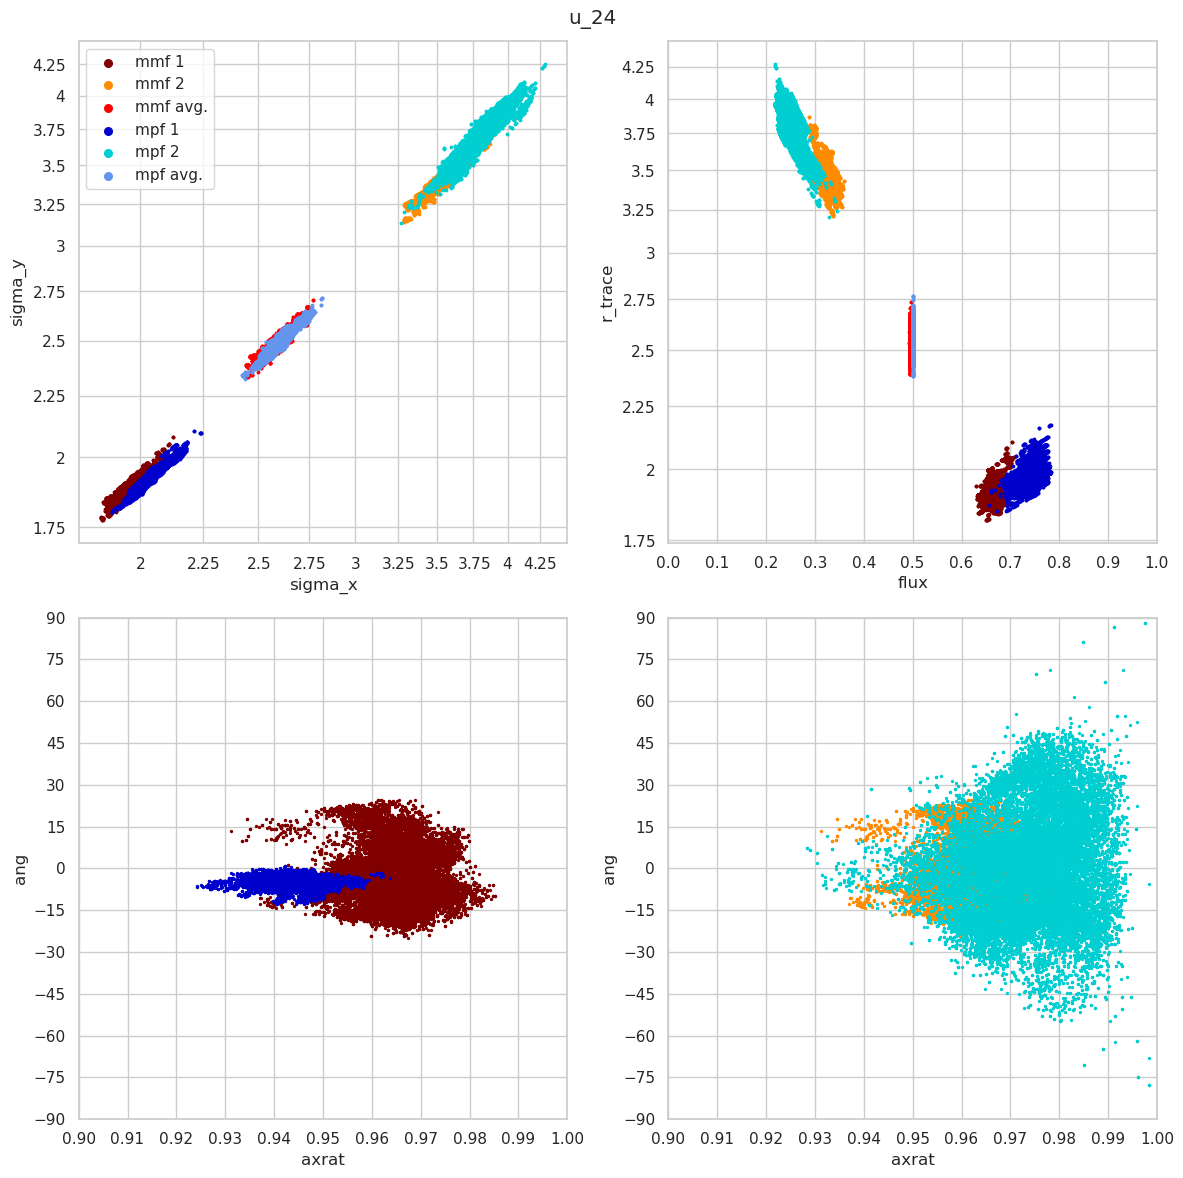

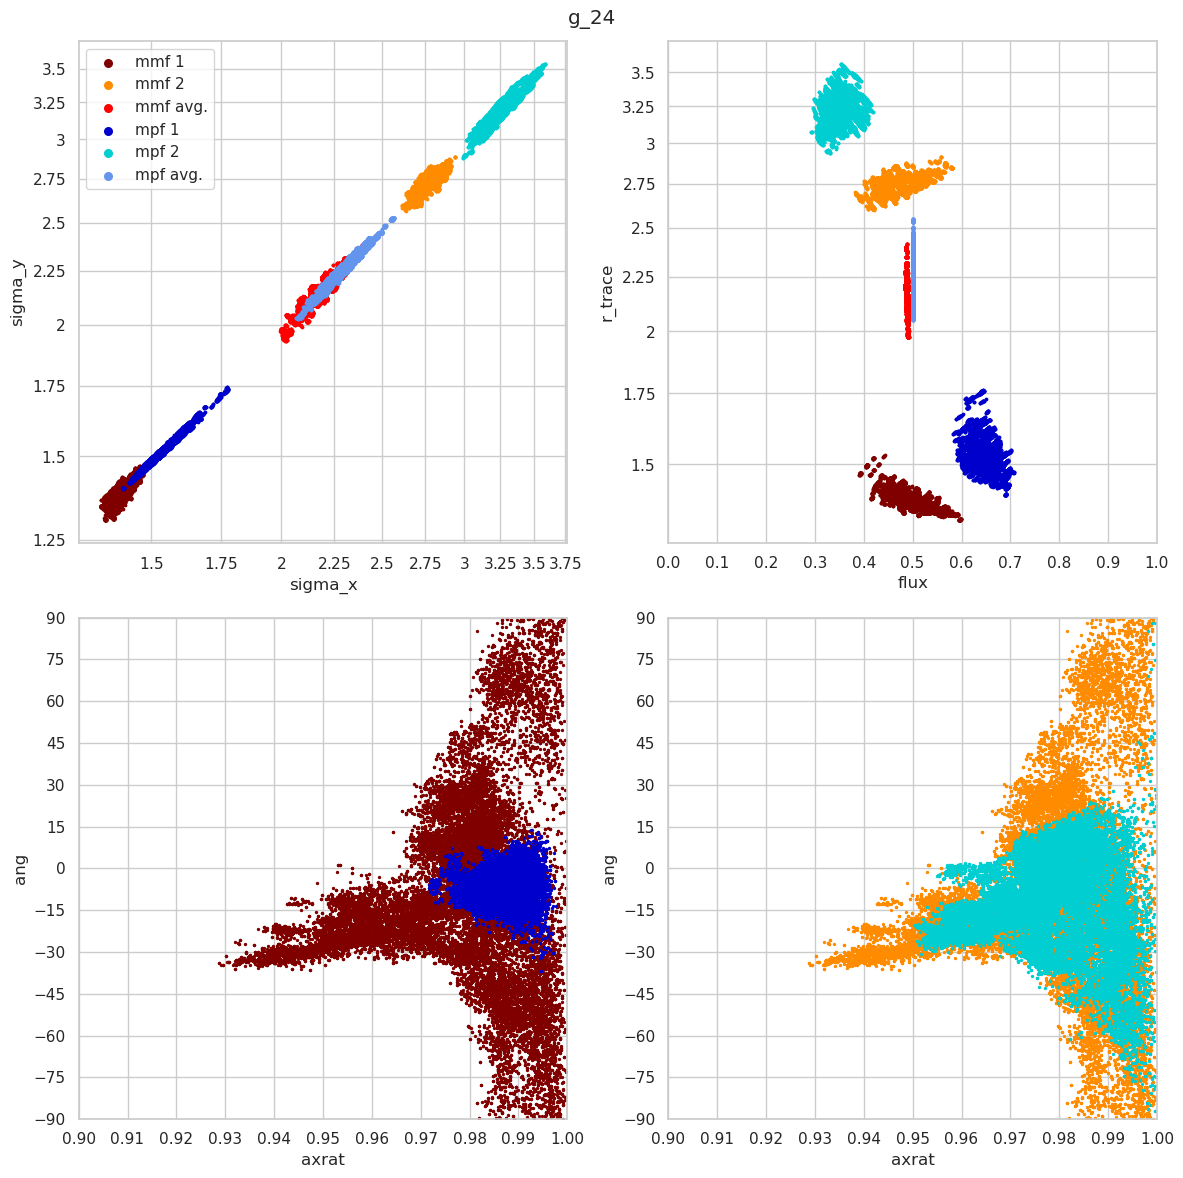

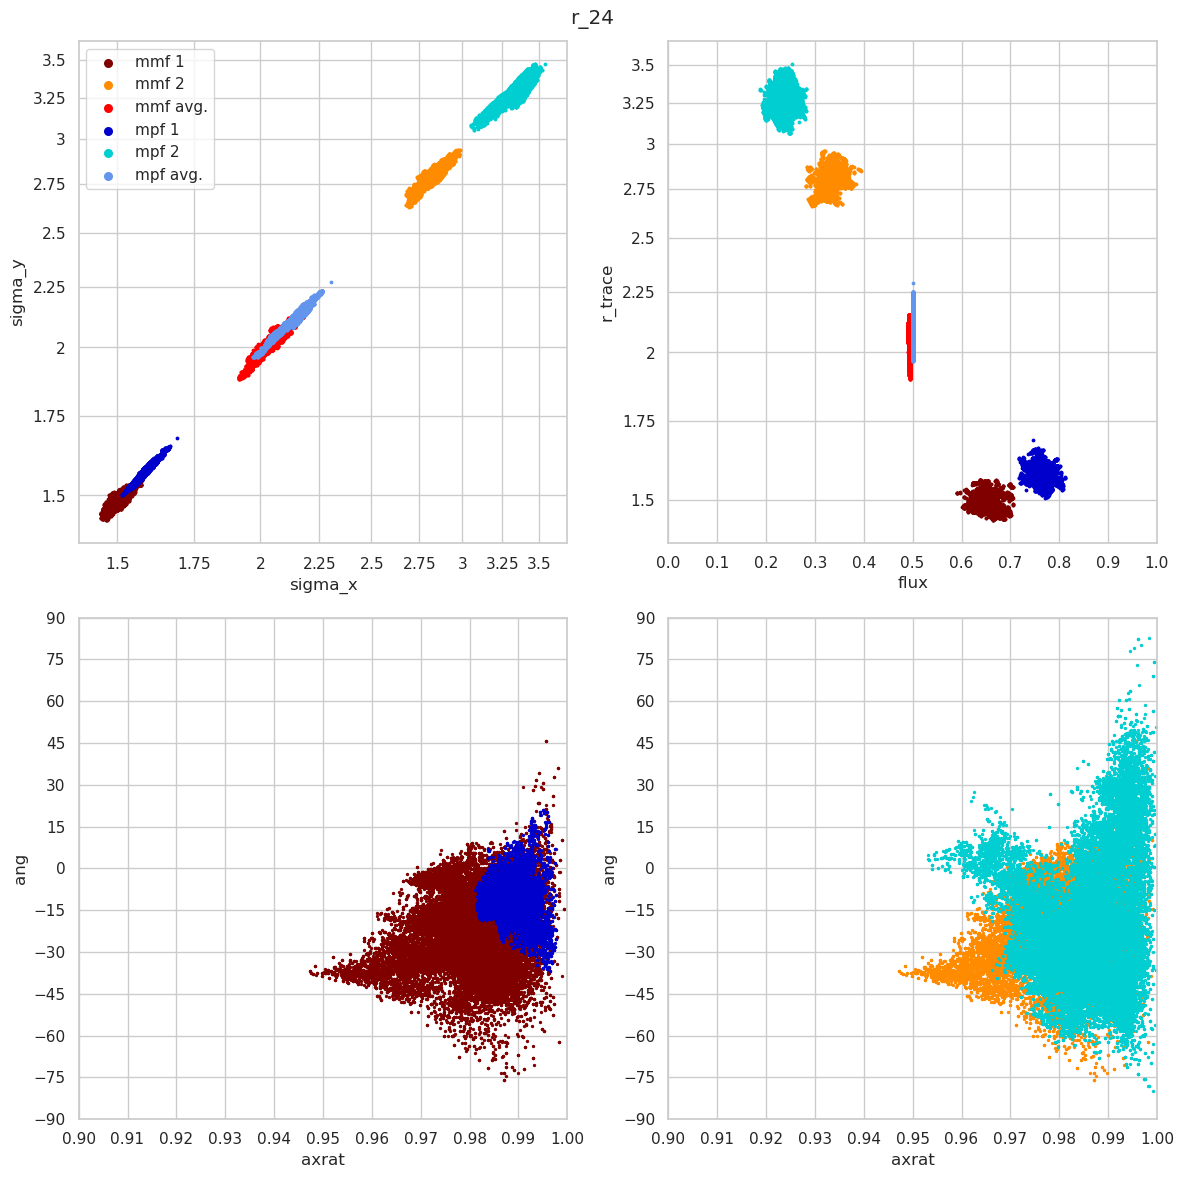

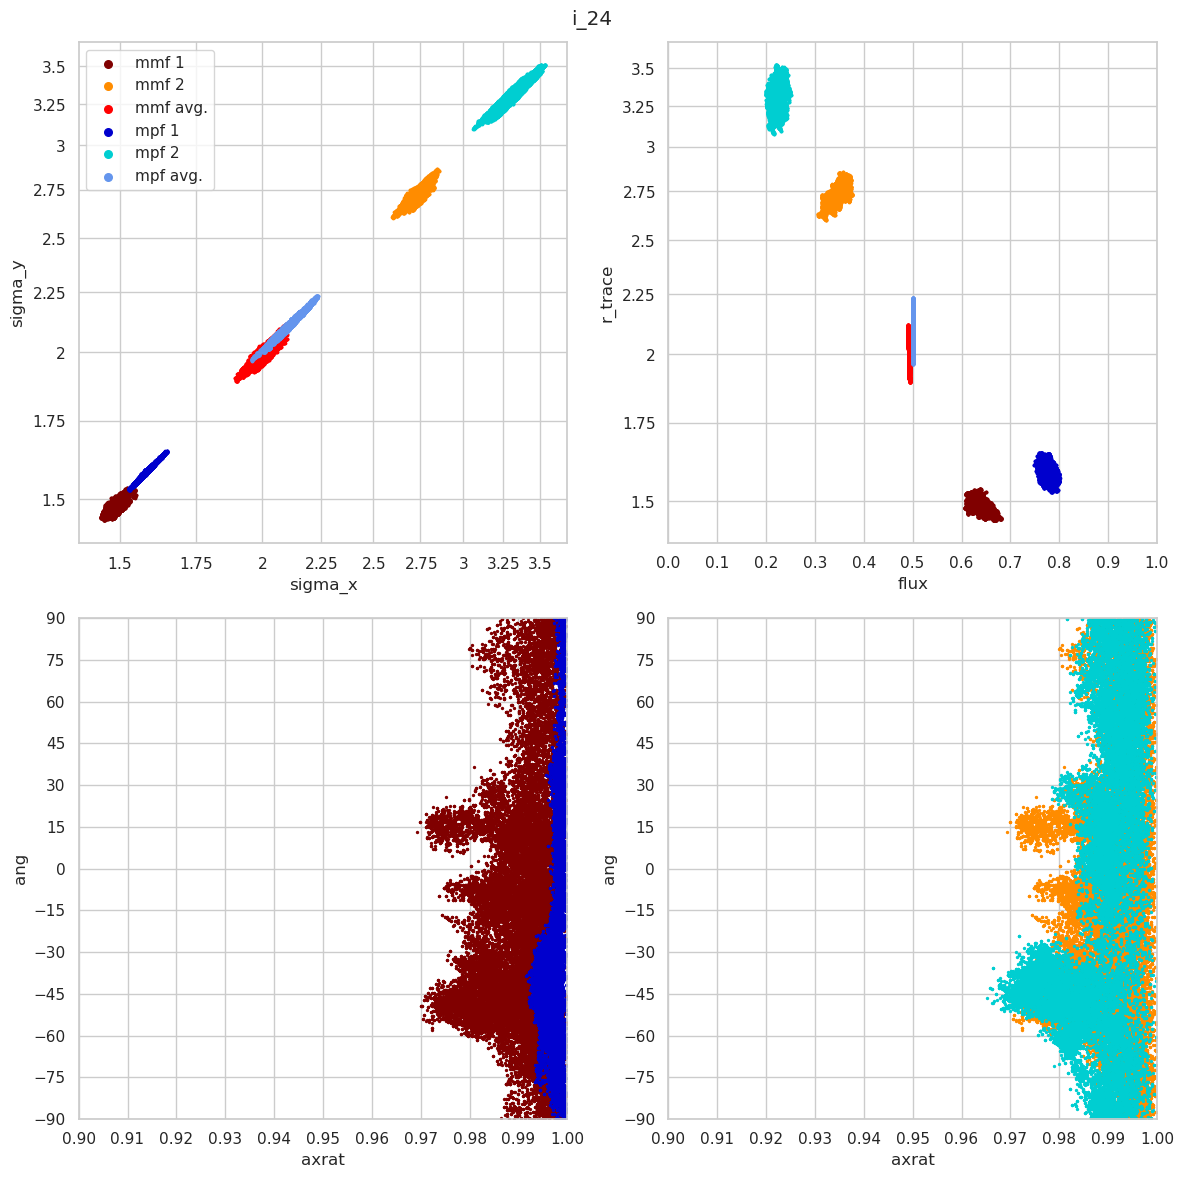

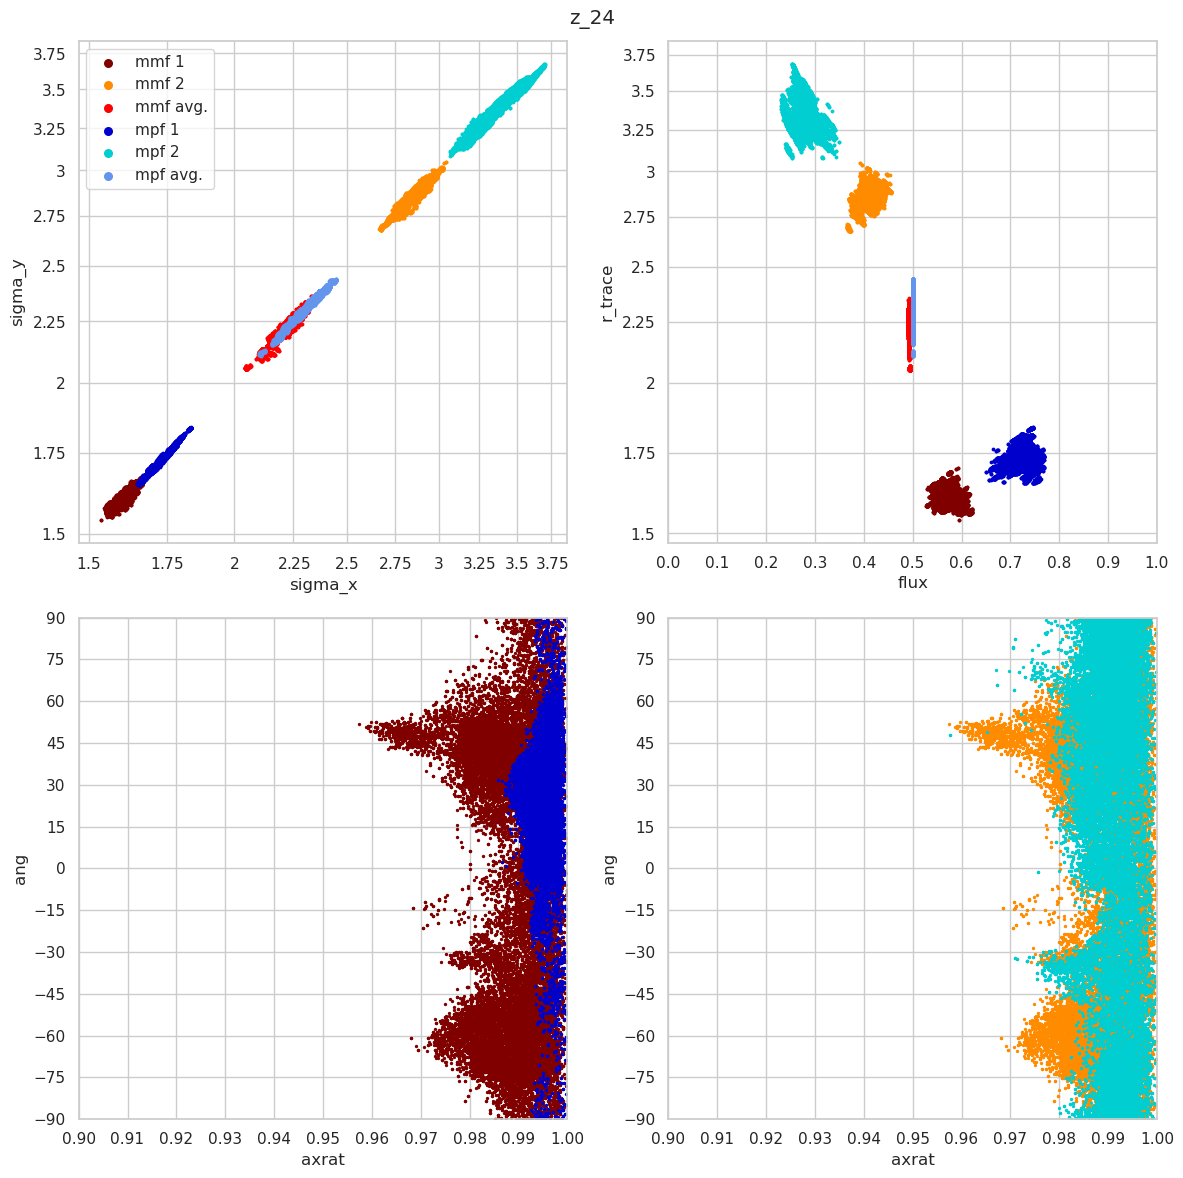

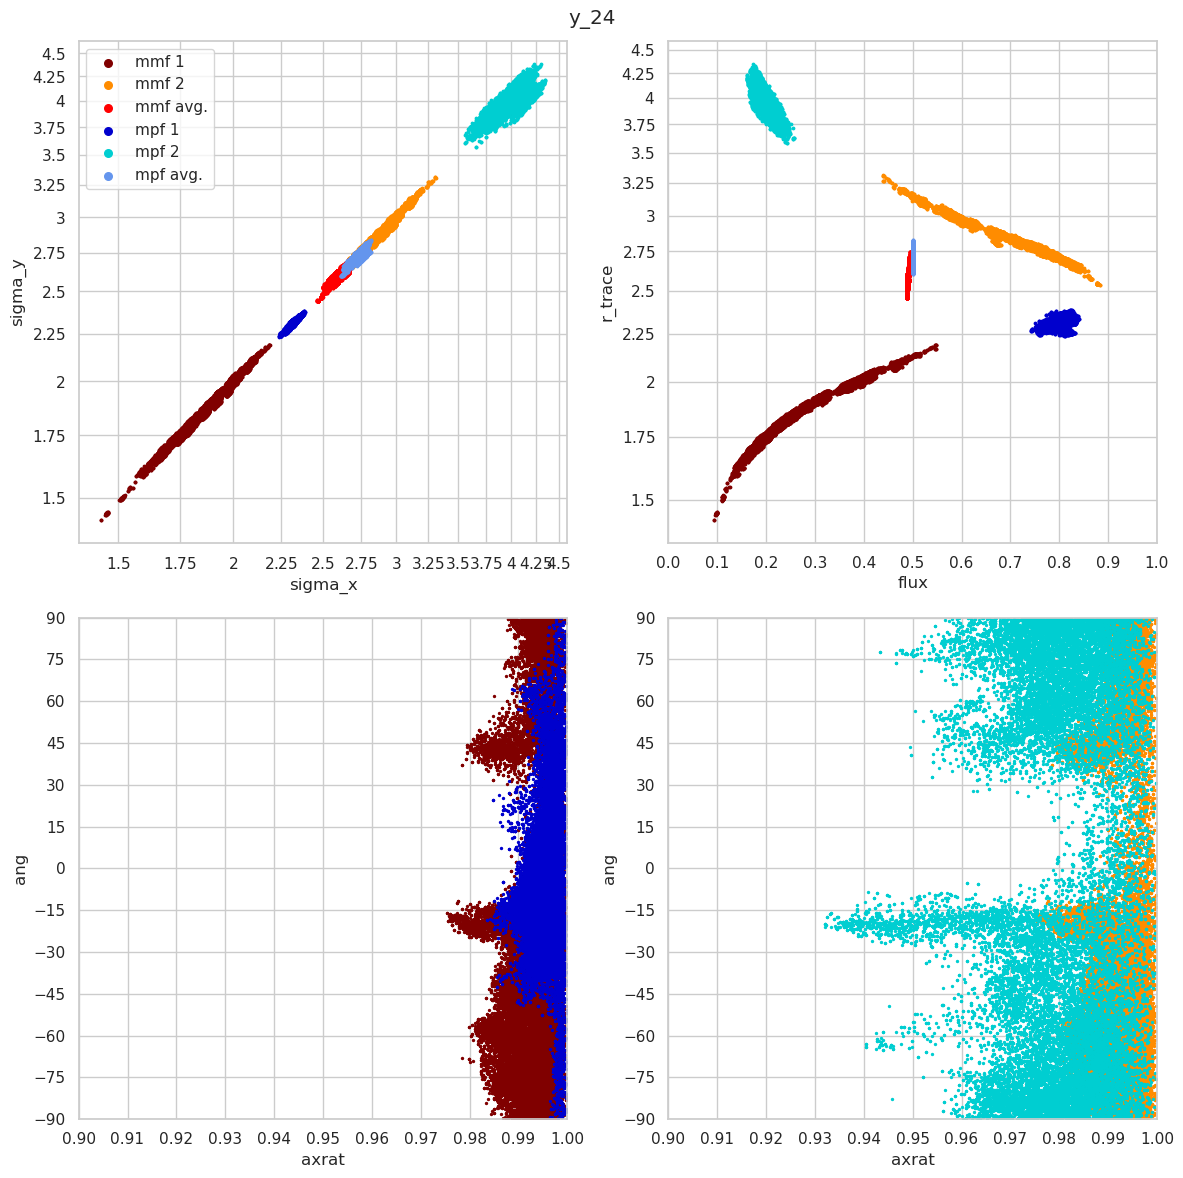

In [4]:
# plot PSF parameters
settings = (
    ("mmf", "maroon", "darkorange", "red"),
    ("mpf", "mediumblue", "darkturquoise", "cornflowerblue"),
)
titles = ""
for name_table, table in tables.items():
    fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(12, 12))
    fig.suptitle(name_table)
    ax[0][0].set(xlabel="sigma_x", ylabel="sigma_y", xscale="log", yscale="log")
    ax[0][1].set(xlabel="flux", ylabel="r_trace", yscale="log")
    ax[1][0].set(xlabel="axrat", ylabel="ang")
    ax[1][1].set(xlabel="axrat", ylabel="ang")
    for algo, col1, col2, col_avg in settings:
        prefix = prefixes[algo]
        sigma_xs = [None]*2
        sigma_ys = [None]*2
        rtraces = [None]*2
        fluxes = [None]*2
        kwargs_scatter = {"s": 3}
        for idx_comp, col in ((1, col1), (2, col2)):
            sigma_x = table[f"{prefix}{idx_comp}_sigma_x"]
            sigma_y = table[f"{prefix}{idx_comp}_sigma_y"]
            sigma_xs[idx_comp - 1] = sigma_x
            sigma_ys[idx_comp - 1] = sigma_y
            kwargs_scatter["c"] = col
            ax[0][0].scatter(
                x=sigma_x,
                y=sigma_y,
                label=f"{algo} {idx_comp}",
                **kwargs_scatter
            )
            flux = table[f"{prefix}{idx_comp}_flux"]
            fluxes[idx_comp - 1] = flux
            rtrace = table[f"{prefix}{idx_comp}_rtrace"]
            rtraces[idx_comp - 1] = rtrace
            ax[0][1].scatter(flux, rtrace, **kwargs_scatter)
            ax[1][idx_comp - 1].scatter(
                table[f"{prefix}{idx_comp}_axrat"],
                table[f"{prefix}{idx_comp}_ang"],
                s=2, c=col,
            )
        sigma_xs, sigma_ys, rtraces, fluxes = (np.array(x) for x in (sigma_xs, sigma_ys, rtraces, fluxes))
        kwargs_scatter["c"] = col_avg
        flux_sum = np.sum(fluxes, axis=0)
        ax[0][0].scatter(
            x=np.sqrt(np.sum(fluxes*sigma_xs*sigma_xs, axis=0)/flux_sum),
            y=np.sqrt(np.sum(fluxes*sigma_ys*sigma_ys, axis=0)/flux_sum),
            label=f"{algo} avg.",
            **kwargs_scatter
        )
        legend = ax[0][0].legend()
        for handle in legend.legend_handles:
            handle.set_sizes([30.0])
        ax[0][1].scatter(
            x=flux_sum/2.,
            y=np.sqrt(np.sum(fluxes*rtraces*rtraces, axis=0)/flux_sum),
            label=f"{algo} avg.",
            **kwargs_scatter
        )
    for subaxis in (ax[0][0].xaxis, ax[0][0].yaxis):
        subaxis.set_major_locator(ticker.MultipleLocator(0.25))
    ax[0][1].set_xlim((0, 1))
    for subaxis, spacing in ((ax[0][1].xaxis, 0.1), (ax[0][1].yaxis, 0.25)):
        subaxis.set_major_locator(ticker.MultipleLocator(spacing))
    for axis in ax[1]:
        axis.set_xlim(0.9, 1.0)
        axis.set_ylim(-90, 90)
        for subaxis, spacing in ((axis.xaxis, 0.01), (axis.yaxis, 15)):
            subaxis.set_major_locator(ticker.MultipleLocator(spacing))
    plt.tight_layout()